In [1]:
# %autosave 0

In [2]:
import sys
from pathlib import Path
from os import getcwd
sys.path.append(str(Path(getcwd()).parent))
from os import remove


from datetime import date, timedelta
import codecs
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

from os.path import join, basename

from bulletin import default_input, default_output, root
from bulletin.services.metabase import Metabase
from bulletin.systems.casos_confirmados import CasosConfirmados
from bulletin.systems.notifica import Notifica
from bulletin.utils.static import Municipios
from bulletin.utils.normalize import normalize_hash, normalize_labels, normalize_text, date_hash, normalize_number
from bulletin.utils import static
from bulletin.utils.xls_ import fit_cols

from datetime import datetime
import pyminizip as pz

today = datetime.today()
ontem = today - timedelta(1)
anteontem = ontem - timedelta(1)

municipios = Municipios()
municipios['mun_resid'] = municipios['municipio'].apply(normalize_text)
municipios.loc[municipios['uf']!='PR','mun_resid'] = municipios.loc[municipios['uf']!='PR','municipio'].apply(normalize_text) + '/' + municipios['uf']

import random
limite = 11878


---------------------------------------------------------------

root: C:\sesa\dev\bulletin
parent: C:\sesa\dev
default_input: C:\sesa\dev\input
default_output: C:\sesa\dev\output

---------------------------------------------------------------



In [3]:
mb = Metabase()
intervalo = "classificacao_final = 2 AND excluir_ficha = 2 AND status_notificacao in (1,2) AND ((data_notificacao >= NOW() - INTERVAL '7 DAY') or (data_liberacao >= NOW() - INTERVAL '7 DAY') or (updated_at >= NOW() - INTERVAL '7 DAY') or (data_coleta >= NOW() - INTERVAL '7 DAY') or (data_encerramento >= NOW() - INTERVAL '7 DAY'))"
mb.generate_notifica_query('update_notifica', where=intervalo)

limit: 100000
Cookie:'13646********-****-****-****-************27d89'
Select 44 columns


"SELECT id, to_char(data_notificacao,'DD/MM/YYYY') AS data_notificacao, to_char(data_encerramento,'DD/MM/YYYY') AS data_encerramento, status_notificacao, origem, to_char(updated_at,'DD/MM/YYYY') AS updated_at, numero_do, classificacao_final, criterio_classificacao, evolucao, to_char(data_cura_obito,'DD/MM/YYYY') AS data_cura_obito, tipo_paciente, cns, cpf, passaporte, etnia, paciente, sexo, to_char(data_nascimento,'DD/MM/YYYY') AS data_nascimento, nome_mae, raca_cor, ocupacao, ocupacao_descricao, cod_cbo, escolaridade, pais_residencia, pais_municipio_residencia, uf_residencia, ibge_residencia, cep_residencia, logradouro_residencia, bairro_residencia, uf_unidade_notifica, ibge_unidade_notifica, to_char(data_cadastro,'DD/MM/YYYY') AS data_cadastro, to_char(data_coleta,'DD/MM/YYYY') AS data_coleta, to_char(data_recebimento,'DD/MM/YYYY') AS data_recebimento, to_char(data_liberacao,'DD/MM/YYYY') AS data_liberacao, requisicao, resultado, exame, metodo, lab_executor, to_char(data_1o_sintomas,

In [4]:
# update_notifica = mb.download_notificacao('update_notifica', load=False, normalize=True)
# update_notifica.save()
# len(update_notifica.df)

In [5]:
notifica = Notifica()
notifica.load()
notifica.check_duplicates()
# notifica.update(update_notifica.df)
notifica.save(replace=True)
casos_notifica = notifica.df
len(notifica.df)

['comorbidades', 'instituicao', 'notifica', 'update_notifica']
loading Notifica from pkl time elepsed:00:00:04
duplicated in  hash_mae : 22476
duplicated in  hash_nasc : 31544
duplicated in  hash_resid : 24797
duplicated in  hash_atend : 23227
duplicated in  hash_diag : 16582
duplicated in  hash_lib : 8665
saving Notifica to pkl time elepsed:00:00:17


1200546

In [6]:
casos_notifica = casos_notifica.loc[(casos_notifica['data_diagnostico'].notna())&(~casos_notifica['duplicated'])]
len(casos_notifica)

In [7]:
casos_notifica = pd.merge(casos_notifica.rename(columns={'ibge_residencia':'ibge'}),municipios[['ibge','rs','mun_resid','uf','municipio']],on='ibge',how='left').rename(columns={'ibge':'ibge_residencia'})
casos_notifica = pd.merge(casos_notifica.rename(columns={'ibge_unidade_notifica':'ibge'}),municipios[['ibge','mun_resid']].rename(columns={'mun_resid':'mun_atend'}),on='ibge',how='left').rename(columns={'ibge':'ibge_unidade_notifica'})
casos_notifica = casos_notifica.loc[casos_notifica['rs'].notna()]
casos_notifica = casos_notifica.loc[casos_notifica['pais_residencia']==1]

casos_notifica = pd.merge(casos_notifica,pd.read_csv(join(root,'resources','tables','exame.csv')).rename(columns={'exame':'exame_name','id':'exame'}), on='exame', how='left')

casos_notifica = casos_notifica.loc[casos_notifica['sexo']!=3]
casos_notifica.loc[casos_notifica['sexo']==1,'sexo'] = 'M'
casos_notifica.loc[casos_notifica['sexo']==2,'sexo'] = 'F'

len(casos_notifica)

1162063

In [8]:
cc = CasosConfirmados()
cc.load()

['cc_19_06_2021']
loading Casos Confirmados from pkl time elepsed:00:00:03


In [9]:
casos_confirmados = cc.df
len(casos_confirmados)

1192936

In [10]:
casos_confirmados = pd.merge(casos_confirmados.rename(columns={'ibge_residencia':'ibge'}),municipios,how='left',on='ibge').rename(columns={'ibge':'ibge_residencia'})
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

,identificacao
evolucao,
1,832308
2,29975
3,330653


In [11]:
novos_casos = casos_notifica.loc[~(
    (casos_notifica['id'].isin(casos_confirmados['id_notifica'])) |
    (casos_notifica['hash_resid'].isin(casos_confirmados['hash_resid'])) |
    (casos_notifica['hash_resid'].isin(casos_confirmados['hash_resid_less'])) |
    (casos_notifica['hash_resid'].isin(casos_confirmados['hash_resid_more'])) |
    (casos_notifica['hash_atend'].isin(casos_confirmados['hash_atend'])) |
    (casos_notifica['hash_atend'].isin(casos_confirmados['hash_atend_less'])) |
    (casos_notifica['hash_atend'].isin(casos_confirmados['hash_atend_more'])) |
    (casos_notifica['hash_diag'].isin(casos_confirmados['hash_diag'])) |
    (casos_notifica['hash_lib'].isin(casos_confirmados['hash_diag']))
)].copy()


novos_casos['data_com'] = pd.to_datetime(date.today())
novos_casos = novos_casos.sort_values(['data_diagnostico','paciente'])

len(novos_casos)

47199

<AxesSubplot:xlabel='data_diagnostico'>

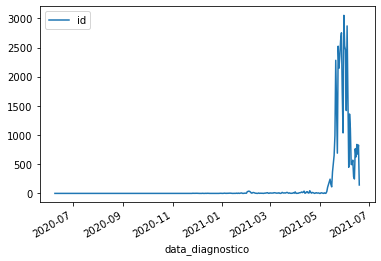

In [12]:
novos_casos[['id','data_diagnostico']].groupby('data_diagnostico').count().plot()

In [13]:
obitos_notifica = casos_notifica.loc[casos_notifica['evolucao']==2]
obitos_casos = casos_confirmados.loc[casos_confirmados['evolucao']==2]

novos_obitos = obitos_notifica.loc[~(
    (obitos_notifica['id'].isin(obitos_casos['id_notifica'])) |
    (obitos_notifica['hash_resid'].isin(obitos_casos['hash_resid'])) |
    (obitos_notifica['hash_resid'].isin(obitos_casos['hash_resid_less'])) |
    (obitos_notifica['hash_resid'].isin(obitos_casos['hash_resid_more'])) |
    (obitos_notifica['hash_atend'].isin(obitos_casos['hash_atend'])) |
    (obitos_notifica['hash_atend'].isin(obitos_casos['hash_atend_less'])) |
    (obitos_notifica['hash_atend'].isin(obitos_casos['hash_atend_more'])) |
    (obitos_notifica['hash_diag'].isin(obitos_casos['hash_diag'])) |
    (obitos_notifica['hash_lib'].isin(obitos_casos['hash_diag']))
)]

novos_obitos = novos_obitos.loc[novos_obitos['data_cura_obito'].notna()]
novos_obitos = novos_obitos.loc[novos_obitos['hash_resid'].isin(casos_confirmados['hash_resid'].tolist() + novos_casos['hash_resid'].tolist())]
novos_obitos = novos_obitos.sort_values(['paciente'])

novos_obitos = novos_obitos.loc[novos_obitos['data_cura_obito'].notna()]
len(novos_obitos)

0

<AxesSubplot:xlabel='data_cura_obito'>

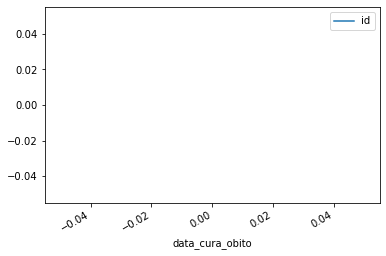

In [14]:
novos_obitos[['id','data_cura_obito']].groupby('data_cura_obito').count().plot()

In [15]:
dias_apos = [1,2,3,7,14,21,30,60,90]
dias_apos_label = ['hoje','24 horas','48 horas', '72 horas', '7 dias', '14 dias', '21 dias', '30 dias', '60 dias', '90 dias']

In [16]:
novos_obitos['dias_apos_obito'] = (today - novos_obitos['data_cura_obito']).dt.days
novos_obitos['periodo_obito'] = [ x for x in np.digitize(novos_obitos['dias_apos_obito'],dias_apos,right=False)]
periodo_novos_obitos = novos_obitos[['id','periodo_obito']].groupby('periodo_obito').count().rename(columns={'id':'qtde'})
periodo_novos_obitos['periodo'] = [ dias_apos_label[x] for x in periodo_novos_obitos.index ]
periodo_novos_obitos[['periodo','qtde']]

,periodo,qtde
periodo_obito,,
0,hoje,2
1,24 horas,12
2,48 horas,14
3,72 horas,18
4,7 dias,39
5,14 dias,50
6,21 dias,124
7,30 dias,42


In [17]:
novos_obitos[['id','paciente','sexo','idade','mun_resid', 'rs', 'data_cura_obito','hash']].to_excel(join(default_output,f"novos_obitos_{(datetime.today().strftime('%d/%m/%Y_%Hh').replace('/','_').replace(' ',''))}.xlsx"))

In [18]:
novos_casos['dias_apos_diagnostico'] = (today - novos_casos['data_diagnostico']).dt.days
novos_casos['periodo_diagnostico'] = [ x for x in np.digitize(novos_casos['dias_apos_diagnostico'],dias_apos,right=False)]
periodo_novos_casos = novos_casos[['id','periodo_diagnostico']].groupby('periodo_diagnostico').count().rename(columns={'id':'qtde'})
periodo_novos_casos['periodo'] = [ dias_apos_label[x] for x in periodo_novos_casos.index ]
periodo_novos_casos[['periodo','qtde']]

,periodo,qtde
periodo_diagnostico,,
0,hoje,293
1,24 horas,1729
2,48 horas,1509
3,72 horas,5202
4,7 dias,10255
5,14 dias,15864
6,21 dias,19652
7,30 dias,3884
8,60 dias,431


In [19]:
novos_casos_alterado = novos_casos.loc[novos_casos['evolucao']==2]
limite -= len(novos_casos_alterado)
novos_casos = novos_casos.loc[~novos_casos['id'].isin(novos_casos_alterado['id'])]

novos_casos_ate_7_dias = novos_casos.loc[novos_casos['periodo_diagnostico'] <= 4 ]
print(f"novos_casos_ate_7_dias {len(novos_casos_ate_7_dias)}")
novos_casos_apos_7_dias = novos_casos.loc[novos_casos['periodo_diagnostico'] > 4 ]
print(f"novos_casos_apos_7_dias {len(novos_casos_apos_7_dias)}")

try:
    novos_casos_alterado_ate_7_dias = novos_casos_ate_7_dias.sample(n=round(limite*0.85))
except:
    novos_casos_alterado_ate_7_dias = novos_casos_ate_7_dias

print(f"novos_casos_alterado_ate_7_dias {len(novos_casos_alterado_ate_7_dias)}")
novos_casos_alterado = novos_casos_alterado.append(novos_casos_alterado_ate_7_dias)

try:
    novos_casos_alterado_apos_7_dias = novos_casos_apos_7_dias.sample(n=round(limite*0.15))
except:
    novos_casos_alterado_apos_7_dias = novos_casos_apos_7_dias
    
print(f"novos_casos_alterado_apos_7_dias {len(novos_casos_alterado_apos_7_dias)}")
novos_casos_alterado = novos_casos_alterado.append(novos_casos_alterado_apos_7_dias)

novos_casos = novos_casos.loc[~novos_casos['id'].isin(novos_casos_alterado['id'])]

print(f"\nSerão adicionados {len(novos_casos_alterado)} novos_casos")
print(f"faltam {len(novos_casos)} novos_casos para adicionar")
novos_casos.to_excel(join(default_output,f"novos_casos_para_adicionar_{(datetime.today().strftime('%d/%m/%Y_%Hh').replace('/','_').replace(' ',''))}.xlsx"))

novos_casos_ate_7_dias 18958
novos_casos_apos_7_dias 40311
novos_casos_alterado_ate_7_dias 9942
novos_casos_alterado_apos_7_dias 1754

Serão adicionados 11878 novos_casos
faltam 47573 novos_casos para adicionar


<AxesSubplot:xlabel='data_diagnostico'>

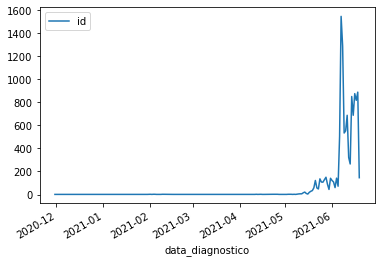

In [20]:
novos_casos = novos_casos_alterado
novos_casos[['id','data_diagnostico']].groupby('data_diagnostico').count().plot()

In [21]:
novos_casos[['id','paciente','sexo','idade','mun_resid', 'mun_atend', 'rs', 'exame_name','data_diagnostico','data_com','data_1o_sintomas','hash']].to_excel(join(default_output,f"novos_casos_{(datetime.today().strftime('%d/%m/%Y_%Hh').replace('/','_').replace(' ',''))}.xlsx"))

In [22]:
print(len(casos_confirmados), end=' ')
duplicados = casos_confirmados.loc[casos_confirmados.duplicated('hash',keep='first')]
print(f" - {len(duplicados)} ", end='= ')
casos_confirmados = casos_confirmados.drop(index=duplicados.index)
print(len(casos_confirmados))
duplicados.to_excel(join(default_output,'exclusoes.xlsx'))

1181439  - 381 = 1181058


In [23]:
date_parser = lambda x: x
relatorio_file = join(default_output,f"relatorio_{(datetime.today().strftime('%d/%m/%Y_%Hh').replace('/','_').replace(' ',''))}.txt")
# relatorio_file = join(default_output,f"relatorio_all.txt")
relatorio_file

'C:\\sesa\\dev\\output\\relatorio_19_06_2021_12h.txt'

In [24]:
casos_confirmadosPR = casos_confirmados.loc[casos_confirmados['rs']!=99]

obitos_confirmados =  casos_confirmados.loc[casos_confirmados['evolucao']==2]

obitos_confirmadosPR = obitos_confirmados.loc[obitos_confirmados['rs']!=99]

print(f"Total de casos: {len(casos_confirmados)} + {len(novos_casos)}")
print(f"Total de obitos: {len(obitos_confirmados)} + {len(novos_obitos)}\n\n")

novos_casosPR = novos_casos.loc[novos_casos['rs']!=99].copy()
print(f"Total de casos PR: {len(casos_confirmadosPR)} + {len(novos_casosPR)}")

novos_obitosPR = novos_obitos.loc[novos_obitos['rs']!=99].copy()
print(f"Total de obitos PR: {len(obitos_confirmadosPR)} + {len(novos_obitosPR)}")

novos_casosFora = novos_casos.loc[novos_casos['rs']==99].copy()
print(f"Total de casos Fora: {len(casos_confirmados) - len(casos_confirmadosPR)} + {len(novos_casosFora)}")

novos_obitosFora = novos_obitos.loc[novos_obitos['rs']==99].copy()
print(f"Total de obitos Fora: {len(obitos_confirmados) - len(obitos_confirmadosPR)} + {len(novos_obitosFora)}")


novos_obitosPR_group = novos_obitosPR.groupby(by='municipio')

data_retroativos = ontem - timedelta(14)

retroativos = novos_casosPR.loc[(novos_casosPR['data_diagnostico'].apply(date_parser) <= data_retroativos)].sort_values(by='data_diagnostico')
last2weeks = novos_casosPR.loc[(novos_casosPR['data_diagnostico'].apply(date_parser) > data_retroativos) & (novos_casosPR['data_diagnostico'].apply(date_parser) <= anteontem)].sort_values(by='data_diagnostico')
hoje = novos_casosPR.loc[(novos_casosPR['data_diagnostico'].apply(date_parser) > anteontem)].sort_values(by='data_diagnostico')

obitos_retroativos = novos_obitosPR.loc[(novos_obitosPR['data_cura_obito'].apply(date_parser) <= data_retroativos)].sort_values(by='data_cura_obito')
obitos_last2weeks = novos_obitosPR.loc[(novos_obitosPR['data_cura_obito'].apply(date_parser) > data_retroativos) & (novos_obitosPR['data_cura_obito'].apply(date_parser) <= anteontem)].sort_values(by='data_cura_obito')
obitos_hoje = novos_obitosPR.loc[(novos_obitosPR['data_cura_obito'].apply(date_parser) > anteontem)].sort_values(by='data_cura_obito')

# relatorio_file = join(default_output,f"relatorio_{(today.strftime('%d/%m/%Y_%Hh').replace('/','_').replace(' ',''))}.txt")
with codecs.open(relatorio_file,"w","utf-8-sig") as relatorio:
    relatorio.write(f"{today.strftime('%d/%m/%Y')}\n")
    relatorio.write(f"{len(novos_casosPR):,} novos casos residentes ".replace(',','.'))

    if len(novos_casosFora) > 0:
        relatorio.write(f"e {len(novos_casosFora):,} não residente{'s' if len(novos_casosFora) > 1 else ''} ".replace(',','.'))
    relatorio.write(f"divulgados no PR.\n")

    relatorio.write(f"{len(casos_confirmadosPR)+len(novos_casosPR):,} casos confirmados residentes do PR.\n".replace(',','.'))
    relatorio.write(f"{len(casos_confirmados)+len(novos_casos):,} total geral.\n\n".replace(',','.'))
    relatorio.write(f"{len(novos_obitosPR):,} Óbitos residentes do PR:\n".replace(',','.'))

    for municipio, obitos in novos_obitosPR_group:
        relatorio.write(f"{len(obitos):,} {municipio}\n".replace(',','.'))

    if len(novos_obitosFora) > 0:
        relatorio.write('\n')
        relatorio.write(f"{len(novos_obitosFora):,} Óbito{'s' if len(novos_obitosFora) > 1 else ''} não residente{'s' if len(novos_obitosFora) > 1 else ''} do PR.\n".replace(',','.'))

    relatorio.write('\n')
    relatorio.write(f"{len(obitos_confirmadosPR)+len(novos_obitosPR):,} óbitos residentes do PR.\n".replace(',','.'))
    relatorio.write(f"{len(obitos_confirmados)+len(novos_obitos):,} total geral.\n\n".replace(',','.'))

    for _, row in novos_obitos.iterrows():
       relatorio.write(f"{row['sexo']}\t{int(row['idade'])}\t{row['municipio'] if row['rs']!=99 else (row['municipio']+'/'+row['uf'])}\t{str(int(row['rs'])).zfill(2) if row['rs']!=99 else '#N/D'}\t{row['data_cura_obito'].day}/{static.meses[row['data_cura_obito'].month-1]}/{row['data_cura_obito'].year}\n")
    relatorio.write('\n')

    if True:

        #casos
        relatorio.write(f"{len(novos_casosPR):,} novos casos residentes divulgados no PR.\n".replace(',','.'))

        relatorio.write(f"{len(retroativos):,} casos retroativos confirmados no período de {retroativos.iloc[0]['data_diagnostico'].strftime('%d/%m/%Y')} à {retroativos.iloc[-1]['data_diagnostico'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(last2weeks):,} novos casos confirmados no período de {last2weeks.iloc[0]['data_diagnostico'].strftime('%d/%m/%Y')} à {last2weeks.iloc[-1]['data_diagnostico'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(hoje):,} novos casos confirmados hoje.\n\n".replace(',','.'))


        novos_casosPR['month'] = novos_casosPR.apply(lambda x: x['data_diagnostico'].month, axis=1)
        novos_casosPR['year'] = novos_casosPR.apply(lambda x: x['data_diagnostico'].year, axis=1)
        relatorio.write('Novos casos por meses:\n')
        for group, value in novos_casosPR.groupby(by=['year','month']):
            relatorio.write(f"{static.meses[int(group[1])-1]}\\{group[0]}: {len(value)}\n")
        relatorio.write('\n')
        
        relatorio.write('Novos casos por dia:\n')
        for group, value in novos_casosPR.groupby(by='data_diagnostico'):
            relatorio.write(f"{group.strftime('%d/%m/%Y')}\t{len(value)}\n")
        relatorio.write('\n')

        #obitos
        relatorio.write(f"{len(novos_obitosPR):,} novos obitos residentes divulgados no PR.\n".replace(',','.'))

        relatorio.write(f"{len(obitos_retroativos):,} obitos retroativos ocorridos no período de {obitos_retroativos.iloc[0]['data_cura_obito'].strftime('%d/%m/%Y')} à {obitos_retroativos.iloc[-1]['data_cura_obito'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(obitos_last2weeks):,} novos obitos ocorridos no período de {obitos_last2weeks.iloc[0]['data_cura_obito'].strftime('%d/%m/%Y')} à {obitos_last2weeks.iloc[-1]['data_cura_obito'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(obitos_hoje):,} novos obitos ocorridos hoje.\n\n".replace(',','.'))

        relatorio.write('Novos obitos por meses:\n')
        novos_obitosPR['month'] = novos_obitosPR.apply(lambda x: x['data_cura_obito'].month, axis=1)
        novos_obitosPR['year'] = novos_obitosPR.apply(lambda x: x['data_cura_obito'].year, axis=1)
        for group, value in novos_obitosPR.groupby(by=['year','month']):
            relatorio.write(f"{static.meses[int(group[1])-1]}\\{group[0]}: {len(value)}\n")
        relatorio.write('\n')

        relatorio.write('Novos obitos por dia:\n')
        for group, value in novos_obitosPR.groupby(by='data_cura_obito'):
            relatorio.write(f"{group.strftime('%d/%m/%Y')}\t{len(value)}\n")
        relatorio.write('\n')

        #-----RELATÓRIO DA COMUNICAÇÃO--------------
        obitos_list = []
        munic = []
        for municipio, obitos in novos_obitosPR_group:
            obito = len(obitos)
            obitos_list.append(obito)
            munic.append(municipio)             

        dicionario = (dict(zip(list(munic),list(obitos_list))))
        #print(dicionario)
        dicionario = sorted(dicionario.items(),key=lambda x: x[1], reverse = True)
        #print(dicionario)


        relatorio.write(f"\nOs pacientes que foram a óbito residiam em: ")
        for municip, obit in dict(dicionario).items():
            if obit != 1:
                relatorio.write(f"{municip} ({obit})")
                relatorio.write(f", ")
        relatorio.write(f".\n")
        relatorio.write(f"A Sesa registra ainda a morte de uma pessoa que residia em cada um dos seguintes municípios:")
        for municip, obit in dict(dicionario).items():
            if obit == 1:
                relatorio.write(f"{municip}")
                relatorio.write(f", ")


Total de casos: 1181058 + 11878
Total de obitos: 29674 + 301


Total de casos PR: 1174748 + 11839
Total de obitos PR: 29508 + 299
Total de casos Fora: 6310 + 39
Total de obitos Fora: 166 + 2


In [25]:
with codecs.open(relatorio_file,"r","utf-8-sig") as relatorio:
    print(relatorio.read())

19/06/2021
11.839 novos casos residentes e 39 não residentes divulgados no PR.
1.186.587 casos confirmados residentes do PR.
1.192.936 total geral.

299 Óbitos residentes do PR:
1 Almirante Tamandaré
1 Alto Paraíso
2 Altônia
2 Antonina
1 Antônio Olinto
17 Apucarana
7 Arapongas
3 Araucária
1 Bandeirantes
1 Bom Sucesso
1 Cafeara
1 Califórnia
1 Cambará
1 Cambira
1 Cambé
4 Campina da Lagoa
2 Campo Largo
8 Campo Mourão
1 Carlópolis
2 Cascavel
3 Cerro Azul
1 Cianorte
1 Clevelândia
5 Colombo
2 Cruz Machado
3 Cruzeiro do Oeste
44 Curitiba
1 Dois Vizinhos
2 Fazenda Rio Grande
14 Foz do Iguaçu
1 Francisco Beltrão
3 General Carneiro
3 Goioerê
10 Guarapuava
1 Guaíra
2 Ibaiti
1 Ibema
2 Imbituva
1 Ivaiporã
3 Lapa
2 Laranjeiras do Sul
20 Londrina
1 Mandaguari
1 Manoel Ribas
14 Maringá
1 Mariópolis
1 Medianeira
1 Miraselva
2 Nova Esperança
2 Nova Fátima
1 Nova Londrina
1 Nova Prata do Iguaçu
1 Nova Santa Rosa
2 Paiçandu
1 Palmas
1 Palmital
1 Paranacity
6 Paranaguá
5 Paranavaí
1 Pato Bragado
4 Pato Bra

In [26]:
cc = CasosConfirmados()
cc.load(f"cc_{ontem.strftime('%d_%m_%Y')}")
casos_confirmados = cc.df
casos_confirmados = casos_confirmados.drop(index=duplicados.index)
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

databases: ['cc_18_06_2021', 'cc_19_06_2021']
Load C:\sesa\dev\bulletin\database\casos_confirmados\cc_18_06_2021.pkl
loading Casos Confirmados from pkl time elepsed:00:00:03


,identificacao
evolucao,
1,830757
2,29674
3,320627


In [27]:
# import time

# while True:
#     time.sleep(0.05)
#     print('a',end='')

In [28]:
novos_casos = novos_casos.rename(columns={
    'id':'id_notifica',
    'ibge_residencia': 'ibge_resid',
    'ibge_unidade_notifica': 'ibge_atend',
    'paciente':'nome',
    'sexo': 'sexo',
    'idade':'idade',
    'exame': 'laboratorio',
    'data_diagnostico':'dt_diag',
    'data_com':'comunicacao',
    'data_1o_sintomas': 'is',
    'evolucao': 'evolucao',
    'data_cura_obito': 'data_evolucao',
    'uf': 'uf_resid'
})

novos_casos = novos_casos[['id_notifica', 'uf_resid', 'ibge_resid', 'ibge_atend', 'nome', 'sexo', 'idade', 'laboratorio', 'dt_diag', 'comunicacao', 'is', 'evolucao', 'data_evolucao']]

novos_casos.loc[novos_casos['evolucao']==5,'evolucao'] = 2
novos_casos.loc[~novos_casos['evolucao'].isin([1,2,3]),'evolucao'] = 3
novos_casos.loc[novos_casos['evolucao']==2,'evolucao'] = 3

novos_casos['hash'] = (novos_casos['nome'].apply(normalize_hash) +
                  novos_casos['idade'].astype(int).astype(str) +
                  novos_casos['ibge_resid'].astype(int).astype(str) )

novos_casos['hash_less'] = ( novos_casos['nome'].apply(normalize_hash) +
                        novos_casos['idade'].apply(lambda x: str(x - 1)) +
                        novos_casos['ibge_resid'].astype(str) )

novos_casos['hash_more'] = ( novos_casos['nome'].apply(normalize_hash) +
                        novos_casos['idade'].apply(lambda x: str(x + 1)) +
                        novos_casos['ibge_resid'].astype(str) )

novos_casos['hash_atend'] = (novos_casos['nome'].apply(normalize_hash) +
                    novos_casos['idade'].astype(str) +
                    novos_casos['ibge_atend'].apply(str) )

novos_casos['hash_less_atend'] = (novos_casos['nome'].apply(normalize_hash) +
                    novos_casos['idade'].apply(lambda x: str(x-1)) +
                    novos_casos['ibge_atend'].apply(str) )

novos_casos['hash_more_atend'] = (novos_casos['nome'].apply(normalize_hash) +
                    novos_casos['idade'].apply(lambda x: str(x+1)) +
                    novos_casos['ibge_atend'].apply(str) )

novos_casos['identificacao'] = list(range(casos_confirmados.iloc[-1,0] + 1,casos_confirmados.iloc[-1,0] + 1 + len(novos_casos)))

casos_confirmados = casos_confirmados.append(novos_casos)
print(len(casos_confirmados))
# casos_confirmados.groupby('evolucao')[['sexo']].count()
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

1192936


,identificacao
evolucao,
1.0,832331
2.0,29674
3.0,330931


In [29]:
casos_confirmados.loc[casos_confirmados['hash'].isin(novos_obitos['hash'])]

,identificacao,id_notifica,uf_resid,ibge_resid,ibge_atend,nome,sexo,idade,laboratorio,dt_diag,comunicacao,is,evolucao,data_evolucao,data_com_evolucao,hash,hash_less,hash_more,hash_atend,hash_less_atend,hash_more_atend,hash_diag
548787,630708,-1,PR,412350.0,411605.0,SIDINEIA GUNTZEL MATIELO,F,41.0,Teste Rápido IgM (Imunocromatografia),2021-01-22,2021-01-31,2021-01-20,1.0,2021-01-31,2021-01-31,SIDINEIAGUNTZELMATIELO41412350,SIDINEIAGUNTZELMATIELO40412350,SIDINEIAGUNTZELMATIELO42412350,SIDINEIAGUNTZELMATIELO41411605,SIDINEIAGUNTZELMATIELO40411605,SIDINEIAGUNTZELMATIELO42411605,SIDINEIAGUNTZELMATIELO22012021
670457,752429,-1,PR,412120.0,412120.0,MIGUEL ALVES,M,79.0,"COVID-19, Biologia Molecular",2021-03-04,2021-03-05,2021-02-14,3.0,NaT,NaT,MIGUELALVES79412120,MIGUELALVES78412120,MIGUELALVES80412120,MIGUELALVES79412120,MIGUELALVES78412120,MIGUELALVES80412120,MIGUELALVES04032021
680437,762414,-1,PR,410550.0,410550.0,VITOR NERI CUSTODIO,M,66.0,"COVID-19, Biologia Molecular",2021-03-05,2021-03-06,2021-02-27,1.0,2021-03-12,2021-03-12,VITORNERICUSTODIO66410550,VITORNERICUSTODIO65410550,VITORNERICUSTODIO67410550,VITORNERICUSTODIO66410550,VITORNERICUSTODIO65410550,VITORNERICUSTODIO67410550,VITORNERICUSTODIO05032021
737627,819611,-1,PR,411520.0,411520.0,LAURA GUERRA GRAVENA,F,80.0,Teste Rápido Antígeno (Imunocromatografia),2021-03-09,2021-03-10,2021-03-01,1.0,2021-03-23,2021-03-25,LAURAGUERRAGRAVENA80411520,LAURAGUERRAGRAVENA79411520,LAURAGUERRAGRAVENA81411520,LAURAGUERRAGRAVENA80411520,LAURAGUERRAGRAVENA79411520,LAURAGUERRAGRAVENA81411520,LAURAGUERRAGRAVENA09032021
738531,820515,-1,PR,412780.0,999999.0,MARIA APARECIDA DA SILVA,F,73.0,Sorologia IgA (Quimioluminescência),2021-03-09,2021-03-10,2021-03-06,3.0,NaT,NaT,MARIAAPARECIDADASILVA73412780,MARIAAPARECIDADASILVA72412780,MARIAAPARECIDADASILVA74412780,MARIAAPARECIDADASILVA73999999,MARIAAPARECIDADASILVA72999999,MARIAAPARECIDADASILVA74999999,MARIAAPARECIDADASILVA09032021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187206,1265959,4240745,PR,410940.0,410940.0,SOFIA WINIARSKI DE ALMEIDA MOURA,F,85.0,1,2021-06-15,2021-06-19,2021-06-14,3.0,2021-06-16,NaT,SOFIAWINIARSKIDEALMEIDAMOURA85410940,SOFIAWINIARSKIDEALMEIDAMOURA84.0410940.0,SOFIAWINIARSKIDEALMEIDAMOURA86.0410940.0,SOFIAWINIARSKIDEALMEIDAMOURA85.0410940.0,SOFIAWINIARSKIDEALMEIDAMOURA84.0410940.0,SOFIAWINIARSKIDEALMEIDAMOURA86.0410940.0,NaN
1182361,1265960,4251878,PR,411915.0,411915.0,ZENI GAUDENCIO,F,89.0,27,2021-06-15,2021-06-19,NaT,3.0,2021-06-16,NaT,ZENIGAUDENCIO89411915,ZENIGAUDENCIO88.0411915.0,ZENIGAUDENCIO90.0411915.0,ZENIGAUDENCIO89.0411915.0,ZENIGAUDENCIO88.0411915.0,ZENIGAUDENCIO90.0411915.0,NaN
1183957,1265961,4287114,PR,410840.0,410840.0,OLINTO DIAS DA SILVA,M,71.0,27,2021-06-16,2021-06-19,NaT,3.0,2021-06-17,NaT,OLINTODIASDASILVA71410840,OLINTODIASDASILVA70.0410840.0,OLINTODIASDASILVA72.0410840.0,OLINTODIASDASILVA71.0410840.0,OLINTODIASDASILVA70.0410840.0,OLINTODIASDASILVA72.0410840.0,NaN
1180197,1265962,3763677,PR,411930.0,411930.0,SEBASTIAO DE LIMA,M,59.0,27,2021-06-16,2021-06-19,2021-05-16,3.0,2021-05-16,NaT,SEBASTIAODELIMA59411930,SEBASTIAODELIMA58.0411930.0,SEBASTIAODELIMA60.0411930.0,SEBASTIAODELIMA59.0411930.0,SEBASTIAODELIMA58.0411930.0,SEBASTIAODELIMA60.0411930.0,NaN


In [30]:
novos_obitos = novos_obitos.rename(columns={
    'id': 'id_notifica',
    'data_cura_obito': 'data_evolucao',
    'paciente':'nome'
})

novos_obitos['data_com_evolucao'] = pd.to_datetime(date.today())
novos_obitos['evolucao'] = 2

novos_obitos = novos_obitos[['hash','id_notifica','evolucao','data_evolucao','data_com_evolucao']]
novos_obitos = novos_obitos.set_index('hash')
novos_obitos

,id_notifica,evolucao,data_evolucao,data_com_evolucao
hash,,,,
ADAOVIEIRADEANDRADE51410975,4099682,2,2021-06-18,2021-06-19
ADAUTODONISETELOPESDASILVA52411370,3949898,2,2021-06-17,2021-06-19
ADEGIMARVARELLADOSSANTOS45411840,4130645,2,2021-06-15,2021-06-19
ADEMIRALMEIDAVIDAL57412710,3369847,2,2021-05-28,2021-06-19
ADEMIRANTONIODAROSA67410040,3435469,2,2021-05-13,2021-06-19
...,...,...,...,...
WILSONRAUSIS58412220,4307854,2,2021-04-21,2021-06-19
ZENEIDEDOSSANTOSPINTO89412220,3966210,2,2021-05-25,2021-06-19
ZENIGAUDENCIO89411915,4251878,2,2021-06-16,2021-06-19


In [31]:
casos_confirmados = casos_confirmados.set_index('hash')
casos_confirmados.update(novos_obitos)
casos_confirmados.reset_index(inplace=True)

print(len(casos_confirmados))
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

1192936


,identificacao
evolucao,
1.0,832308
2.0,29975
3.0,330653


In [32]:
novos_obitos = novos_obitos.reset_index()
novos_obitos.loc[novos_obitos.duplicated('hash',keep=False)]

,hash,id_notifica,evolucao,data_evolucao,data_com_evolucao


In [33]:
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

,identificacao
evolucao,
1.0,832308
2.0,29975
3.0,330653


In [34]:
# cc.df = casos_confirmados[['identificacao','id_notifica','uf_resid','ibge_resid','ibge_atend','nome','sexo','idade','laboratorio','dt_diag','comunicacao','is','evolucao','data_evolucao','data_com_evolucao','hash','hash_less','hash_more','hash_atend','hash_less_atend','hash_more_atend','hash_diag']]
# cc.df
casos_confirmados.loc[casos_confirmados['hash'].isin(novos_obitos.index.tolist())]

,hash,identificacao,id_notifica,uf_resid,ibge_resid,ibge_atend,nome,sexo,idade,laboratorio,dt_diag,comunicacao,is,evolucao,data_evolucao,data_com_evolucao,hash_less,hash_more,hash_atend,hash_less_atend,hash_more_atend,hash_diag


In [35]:
cc.df = casos_confirmados[['identificacao','id_notifica','uf_resid','ibge_resid','ibge_atend','nome','sexo','idade','laboratorio','dt_diag','comunicacao','is','evolucao','data_evolucao','data_com_evolucao','hash','hash_less','hash_more','hash_atend','hash_less_atend','hash_more_atend','hash_diag']]
cc.save(f"cc_{today.strftime('%d_%m_%Y')}", replace=True)
cc.df.tail()

Load C:\sesa\dev\bulletin\database\casos_confirmados\cc_19_06_2021.pkl
saving Casos Confirmados to pkl time elepsed:00:00:10


,identificacao,id_notifica,uf_resid,ibge_resid,ibge_atend,nome,sexo,idade,laboratorio,dt_diag,comunicacao,is,evolucao,data_evolucao,data_com_evolucao,hash,hash_less,hash_more,hash_atend,hash_less_atend,hash_more_atend,hash_diag
1192931,1277655,3959574.0,PR,411915.0,411950.0,CARLOS EDUARDO KACHOVIOCK COSTA,M,10.0,167,2021-05-22,2021-06-19,NaT,3.0,NaT,NaT,CARLOSEDUARDOKACHOVIOCKCOSTA10411915,CARLOSEDUARDOKACHOVIOCKCOSTA9.0411915.0,CARLOSEDUARDOKACHOVIOCKCOSTA11.0411915.0,CARLOSEDUARDOKACHOVIOCKCOSTA10.0411950.0,CARLOSEDUARDOKACHOVIOCKCOSTA9.0411950.0,CARLOSEDUARDOKACHOVIOCKCOSTA11.0411950.0,NaN
1192932,1277656,4006340.0,PR,411520.0,411520.0,EDIVALDO LOPES DE OLIVEIRA NETO,M,27.0,167,2021-06-01,2021-06-19,2021-05-30,1.0,2021-06-11,NaT,EDIVALDOLOPESDEOLIVEIRANETO27411520,EDIVALDOLOPESDEOLIVEIRANETO26.0411520.0,EDIVALDOLOPESDEOLIVEIRANETO28.0411520.0,EDIVALDOLOPESDEOLIVEIRANETO27.0411520.0,EDIVALDOLOPESDEOLIVEIRANETO26.0411520.0,EDIVALDOLOPESDEOLIVEIRANETO28.0411520.0,NaN
1192933,1277657,3858354.0,PR,410430.0,410430.0,SINTIA RODRIGUES DOS SANTOS VARELA,F,34.0,167,2021-05-22,2021-06-19,NaT,3.0,NaT,NaT,SINTIARODRIGUESDOSSANTOSVARELA34410430,SINTIARODRIGUESDOSSANTOSVARELA33.0410430.0,SINTIARODRIGUESDOSSANTOSVARELA35.0410430.0,SINTIARODRIGUESDOSSANTOSVARELA34.0410430.0,SINTIARODRIGUESDOSSANTOSVARELA33.0410430.0,SINTIARODRIGUESDOSSANTOSVARELA35.0410430.0,NaN
1192934,1277658,3960596.0,PR,410830.0,410830.0,ALTAIR COLUSSI,M,57.0,167,2021-05-29,2021-06-19,2021-05-27,3.0,NaT,NaT,ALTAIRCOLUSSI57410830,ALTAIRCOLUSSI56.0410830.0,ALTAIRCOLUSSI58.0410830.0,ALTAIRCOLUSSI57.0410830.0,ALTAIRCOLUSSI56.0410830.0,ALTAIRCOLUSSI58.0410830.0,NaN
1192935,1277659,4068777.0,PR,412730.0,412730.0,CARLOS GLEISON RIBEIRO,M,47.0,-1,2021-06-05,2021-06-19,2021-05-29,1.0,2021-06-14,NaT,CARLOSGLEISONRIBEIRO47412730,CARLOSGLEISONRIBEIRO46.0412730.0,CARLOSGLEISONRIBEIRO48.0412730.0,CARLOSGLEISONRIBEIRO47.0412730.0,CARLOSGLEISONRIBEIRO46.0412730.0,CARLOSGLEISONRIBEIRO48.0412730.0,NaN


In [36]:
casos_confirmados = cc.df
casos_confirmados

,identificacao,id_notifica,uf_resid,ibge_resid,ibge_atend,nome,sexo,idade,laboratorio,dt_diag,comunicacao,is,evolucao,data_evolucao,data_com_evolucao,hash,hash_less,hash_more,hash_atend,hash_less_atend,hash_more_atend,hash_diag
0,8838,-1.0,PR,410550.0,410550.0,ELIANA CRISTINA CUNHA DE OLIVEIRA SOUZA,F,47.0,LACEN,2020-03-12,2020-03-12,NaT,1.0,2020-04-03,NaT,ELIANACRISTINACUNHADEOLIVEIRASOUZA47410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA46410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA48410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA47410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA46410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA48410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA12032020
1,10932,-1.0,PR,410690.0,410690.0,FLAMARION PETRIV DE ABREU,M,43.0,LACEN,2020-03-12,2020-03-12,2020-03-07,1.0,NaT,NaT,FLAMARIONPETRIVDEABREU43410690,FLAMARIONPETRIVDEABREU42410690,FLAMARIONPETRIVDEABREU44410690,FLAMARIONPETRIVDEABREU43410690,FLAMARIONPETRIVDEABREU42410690,FLAMARIONPETRIVDEABREU44410690,FLAMARIONPETRIVDEABREU12032020
2,10933,-1.0,PR,410690.0,410690.0,FLAMARION PETRIV DE ABREU JUNIOR,M,15.0,LACEN,2020-03-12,2020-03-12,2020-03-08,1.0,NaT,NaT,FLAMARIONPETRIVDEABREUJUNIOR15410690,FLAMARIONPETRIVDEABREUJUNIOR14410690,FLAMARIONPETRIVDEABREUJUNIOR16410690,FLAMARIONPETRIVDEABREUJUNIOR15410690,FLAMARIONPETRIVDEABREUJUNIOR14410690,FLAMARIONPETRIVDEABREUJUNIOR16410690,FLAMARIONPETRIVDEABREUJUNIOR12032020
3,11470,-1.0,PR,410690.0,410690.0,GABRIELA FUGANTI CASAGRANDE,F,26.0,Genoprimer,2020-03-16,2020-03-12,2020-03-11,1.0,NaT,NaT,GABRIELAFUGANTICASAGRANDE26410690,GABRIELAFUGANTICASAGRANDE25410690,GABRIELAFUGANTICASAGRANDE27410690,GABRIELAFUGANTICASAGRANDE26410690,GABRIELAFUGANTICASAGRANDE25410690,GABRIELAFUGANTICASAGRANDE27410690,GABRIELAFUGANTICASAGRANDE16032020
4,11492,-1.0,PR,410690.0,410690.0,GABRIELA SCHNEIDER GUGELMIN,F,26.0,Genoprimer,2020-03-18,2020-03-12,2020-03-15,1.0,NaT,NaT,GABRIELASCHNEIDERGUGELMIN26410690,GABRIELASCHNEIDERGUGELMIN25410690,GABRIELASCHNEIDERGUGELMIN27410690,GABRIELASCHNEIDERGUGELMIN26410690,GABRIELASCHNEIDERGUGELMIN25410690,GABRIELASCHNEIDERGUGELMIN27410690,GABRIELASCHNEIDERGUGELMIN18032020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192931,1277655,3959574.0,PR,411915.0,411950.0,CARLOS EDUARDO KACHOVIOCK COSTA,M,10.0,167,2021-05-22,2021-06-19,NaT,3.0,NaT,NaT,CARLOSEDUARDOKACHOVIOCKCOSTA10411915,CARLOSEDUARDOKACHOVIOCKCOSTA9.0411915.0,CARLOSEDUARDOKACHOVIOCKCOSTA11.0411915.0,CARLOSEDUARDOKACHOVIOCKCOSTA10.0411950.0,CARLOSEDUARDOKACHOVIOCKCOSTA9.0411950.0,CARLOSEDUARDOKACHOVIOCKCOSTA11.0411950.0,NaN
1192932,1277656,4006340.0,PR,411520.0,411520.0,EDIVALDO LOPES DE OLIVEIRA NETO,M,27.0,167,2021-06-01,2021-06-19,2021-05-30,1.0,2021-06-11,NaT,EDIVALDOLOPESDEOLIVEIRANETO27411520,EDIVALDOLOPESDEOLIVEIRANETO26.0411520.0,EDIVALDOLOPESDEOLIVEIRANETO28.0411520.0,EDIVALDOLOPESDEOLIVEIRANETO27.0411520.0,EDIVALDOLOPESDEOLIVEIRANETO26.0411520.0,EDIVALDOLOPESDEOLIVEIRANETO28.0411520.0,NaN
1192933,1277657,3858354.0,PR,410430.0,410430.0,SINTIA RODRIGUES DOS SANTOS VARELA,F,34.0,167,2021-05-22,2021-06-19,NaT,3.0,NaT,NaT,SINTIARODRIGUESDOSSANTOSVARELA34410430,SINTIARODRIGUESDOSSANTOSVARELA33.0410430.0,SINTIARODRIGUESDOSSANTOSVARELA35.0410430.0,SINTIARODRIGUESDOSSANTOSVARELA34.0410430.0,SINTIARODRIGUESDOSSANTOSVARELA33.0410430.0,SINTIARODRIGUESDOSSANTOSVARELA35.0410430.0,NaN
1192934,1277658,3960596.0,PR,410830.0,410830.0,ALTAIR COLUSSI,M,57.0,167,2021-05-29,2021-06-19,2021-05-27,3.0,NaT,NaT,ALTAIRCOLUSSI57410830,ALTAIRCOLUSSI56.0410830.0,ALTAIRCOLUSSI58.0410830.0,ALTAIRCOLUSSI57.0410830.0,ALTAIRCOLUSSI56.0410830.0,ALTAIRCOLUSSI58.0410830.0,NaN


In [37]:
municipios = Municipios()

macros_idx_labels = dict([ [i,x] for (i,x) in enumerate(['Leste','Oeste','Noroeste','Norte','Fora'])])
macros_labels_idx = dict([ [x,i] for (i,x) in macros_idx_labels.items() ])
municipios['macro'] = municipios['macro'].apply(lambda x: macros_labels_idx[x])

casos_confirmados = pd.merge(casos_confirmados.rename(columns={'ibge_resid':'ibge'}),municipios,on=['ibge'],how='left').rename(columns={'ibge':'ibge_resid'})

casos_confirmados['municipio_pr'] = casos_confirmados['municipio']
casos_confirmados.loc[casos_confirmados['uf_resid']!='PR','municipio_pr'] = 'Fora'

casos_confirmados.loc[casos_confirmados['uf_resid']!='PR','ibge7'] = 9999999

casos_confirmados['uf_pr'] = 'PR'
casos_confirmados.loc[casos_confirmados['uf_resid']!='PR','uf_pr'] = 'Fora'

In [38]:
pd.options.display.float_format = lambda x: '{:,.0f}'.format(x).replace(',','.')

total = casos_confirmados.groupby(['evolucao','uf_pr'])[['sexo']].count().unstack().droplevel(0,1)[['PR','Fora']]
total['GERAL'] = total.sum(1)
total = total.append(pd.Series(total.sum(0),name=0))
total.index = [2,1,3,0]
total = total.sort_index()
total = total.rename(index={0:'CASOS',2:'RECUPERADOS',1:'OBITOS',3:'ATIVOS'})
total.index.name = None
total.columns.name = None

total.astype(float)

,PR,Fora,GERAL
CASOS,1.186.587,6.349,1.192.936
OBITOS,29.807,168,29.975
RECUPERADOS,829.966,2.342,832.308
ATIVOS,326.814,3.839,330.653


In [39]:
total_macros = casos_confirmados.groupby(['macro','evolucao'])[['sexo']].count().unstack()
total_macros.columns = total_macros.columns.droplevel(0)

total_macros['CASOS'] = total_macros.sum(1)
total_macros = total_macros.fillna(0)
total_macros = total_macros.rename(columns={1:'RECUPERADOS',2:'OBITOS',3:'ATIVOS'})
total_macros = total_macros[['CASOS','OBITOS','RECUPERADOS','ATIVOS']]

total_macros.index = [ macros_idx_labels[x] if isinstance(x,int) else x for x in total_macros.index]

total_macros.astype(float)

evolucao,CASOS,OBITOS,RECUPERADOS,ATIVOS
Leste,547.431,14.989,363.642,168.800
Oeste,243.064,5.023,209.752,28.289
Noroeste,195.013,4.343,144.705,45.965
Norte,201.079,5.452,111.867,83.760
Fora,6.349,168,2.342,3.839


In [40]:
total_regionais = casos_confirmados.groupby(['rs','regional','evolucao'])[['sexo']].count().unstack()
total_regionais.columns = total_regionais.columns.droplevel(0)

total_regionais['CASOS'] = total_regionais.sum(1)
total_regionais = total_regionais.fillna(0)
total_regionais = total_regionais.rename(columns={1:'RECUPERADOS',2:'OBITOS',3:'ATIVOS'})
total_regionais = total_regionais[['CASOS','OBITOS','RECUPERADOS','ATIVOS']]

total_regionais.astype(float)

,evolucao,CASOS,OBITOS,RECUPERADOS,ATIVOS
rs,regional,,,,
1,Paranaguá,36.602,933,19.118,16.551
2,Metropolitana,346.671,10.311,240.206,96.154
3,Ponta Grossa,70.483,1.691,46.292,22.500
4,Irati,17.215,357,12.982,3.876
5,Guarapuava,38.581,854,22.748,14.979
6,União da Vitória,12.896,274,9.209,3.413
7,Pato Branco,32.273,763,27.392,4.118
8,Francisco Beltrão,43.563,741,37.249,5.573
9,Foz do Iguaçu,57.860,1.347,46.304,10.209


In [41]:
total_municipios = casos_confirmados.groupby(['macro','rs','regional','ibge7','municipio_pr','evolucao'])[['sexo']].count().unstack()

total_municipios[('','CASOS')] = total_municipios.sum(1)
total_municipios = total_municipios.fillna(0).astype(float)
total_municipios.columns = total_municipios.columns.droplevel(0)
total_municipios = total_municipios.rename(columns={1:'RECUPERADOS',2:'OBITOS',3:'ATIVOS'})
total_municipios = total_municipios[['CASOS','OBITOS','RECUPERADOS','ATIVOS']]

total_municipios.index = total_municipios.index.set_levels([ macros_idx_labels[x] if isinstance(x,int) else x for x in total_municipios.index.levels[0]], level=0)

total_municipios

evolucao                                         CASOS  OBITOS  RECUPERADOS  \
macro rs regional  ibge7   municipio_pr                                       
Leste 1  Paranaguá 4101200 Antonina              2.429      64        2.193   
                   4109500 Guaraqueçaba            648      18          548   
                   4109609 Guaratuba             4.457     161        3.954   
                   4115705 Matinhos              3.088     111        2.637   
                   4116208 Morretes              2.062      52        1.640   
...                                                ...     ...          ...   
Norte 22 Ivaiporã  4122172 Rio Branco do Ivaí      300      11          263   
                   4122651 Rosário do Ivaí         381       2          376   
                   4123857 Santa Maria do Oeste    705      23          624   
                   4125001 São João do Ivaí      1.038      21          880   
Fora  99 Fora      9999999 Fora                  6.349     168        2.342   

evolucao                                         ATIVOS  
macro rs regional  ibge7   municipio_pr                  
Leste 1  Paranaguá 4101200 Antonina                 172  
                   4109500 Guaraqueçaba              82  
                   4109609 Guaratuba                342  
                   4115705 Matinhos                 340  
                   4116208 Morretes                 370  
...                                                 ...  
Norte 22 Ivaiporã  4122172 Rio Branco do Ivaí        26  
                   4122651 Rosário do Ivaí            3  
                   4123857 Santa Maria do Oeste      58  
                   4125001 São João do Ivaí         137  
Fora  99 Fora      9999999 Fora                   3.839  

[400 rows x 4 columns]

In [42]:
total_municipios.loc[(slice(None),slice(None),slice(None),slice(None),'Curitiba')]

,,,evolucao,CASOS,OBITOS,RECUPERADOS,ATIVOS
macro,rs,regional,ibge7,,,,
Leste,2,Metropolitana,4106902,165.913,5.673,108.743,51.497


In [43]:
ministerio_cols = ['ibge7','municipio_pr','macro','CASOS','OBITOS']

ministerio_sort = pd.read_csv(join(default_input,'ministerio_ibge_order.csv'), sep=';')

ministerio = pd.merge(ministerio_sort, total_municipios.reset_index()[ministerio_cols], how='left', on='ibge7' )
del ministerio['ibge7']

ministerio['macro'] = ministerio['macro'].str.upper()

ministerio.loc[399,['municipio_pr']] = 'Fora do Parana'
ministerio.loc[399,['macro']] = ''

ministerio.loc[400,'municipio_pr'] = 'TOTAL GERAL'
ministerio.loc[400,'macro'] = ''
ministerio.loc[400,'CASOS'] = total.loc['CASOS','GERAL']
ministerio.loc[400,'OBITOS'] = total.loc['OBITOS','GERAL']

ministerio.columns = ['Município de residência', 'macro', 'Casos confirmados', 'Óbitos']

writer = pd.ExcelWriter(join(default_output,"Casos confirmados covid19 no PR por município.xlsx"),
                    engine='xlsxwriter')

ministerio.to_excel(writer,'total_municipios', index=False)
fit_cols(writer,ministerio,'total_municipios')

writer.save()

from openpyxl import load_workbook
from openpyxl.styles import Alignment, PatternFill

wb = load_workbook(filename = join(default_output,"Casos confirmados covid19 no PR por município.xlsx"))
sheet = wb['total_municipios']
sheet.insert_rows(1)
sheet.merge_cells(start_row=1, start_column=1, end_row=1, end_column=4)
cell = sheet.cell(row=1, column=1)  
cell.value = 'Casos confirmados covid-19 no Paraná'  
cell.alignment = Alignment(horizontal='center', vertical='center')  
wb.save(filename = join(default_output,"Casos confirmados covid19 no PR por município.xlsx"))

ministerio

,Município de residência,macro,Casos confirmados,Óbitos
0,Antonina,LESTE,2.429,64
1,Guaraqueçaba,LESTE,648,18
2,Guaratuba,LESTE,4.457,161
3,Matinhos,LESTE,3.088,111
4,Morretes,LESTE,2.062,52
...,...,...,...,...
396,Rosário do Ivaí,NORTE,381,2
397,Santa Maria do Oeste,NORTE,705,23
398,São João do Ivaí,NORTE,1.038,21
399,Fora do Parana,,6.349,168


In [44]:
casos_confirmados['regional'] = casos_confirmados['rs'].apply(lambda x: str(x).zfill(2)) +'ª '+ casos_confirmados['regional']
casos_confirmados = casos_confirmados[['id_notifica','macro','regional','ibge_resid','municipio','ibge_atend','nome','sexo','idade', 'laboratorio', 'dt_diag', 'comunicacao', 'is', 'evolucao','data_evolucao', 'data_com_evolucao']].copy()
casos_confirmados.loc[casos_confirmados['evolucao']==1,'evolucao'] = 'CURA'
casos_confirmados.loc[casos_confirmados['evolucao']==2,'evolucao'] = 'OBITO'
casos_confirmados.loc[casos_confirmados['evolucao']==3,'evolucao'] = 'ATIVO'

In [45]:
obitos_confirmados = casos_confirmados.loc[casos_confirmados['evolucao']=='OBITO']

In [46]:
writer = pd.ExcelWriter(join(default_output, f"casos_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

for idx, macro in macros_idx_labels.items():
    casos_macro = casos_confirmados.loc[casos_confirmados['macro']==idx].copy()
    casos_macro['macro'] = macro
    casos_macro.to_excel(writer,macro)
    fit_cols(writer,casos_macro,macro)


writer.save()

In [47]:
writer = pd.ExcelWriter(join(default_output, f"obitos_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

obitos_confirmados.to_excel(writer,'obitos')
fit_cols(writer,obitos_confirmados,'obitos')


writer.save()

In [48]:
# casos_confirmados['rs'].unique()

In [49]:
writer = pd.ExcelWriter(join(default_output,f"casos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

for regional in sorted(casos_confirmados['regional'].unique()):
    casos_regional = casos_confirmados.loc[casos_confirmados['regional']==regional].copy()
    casos_regional['macro'] = casos_regional['macro'].apply(lambda x: macros_idx_labels[x])
    casos_regional.to_excel(writer,regional)
    fit_cols(writer,casos_regional,regional)


writer.save()

In [50]:
writer = pd.ExcelWriter(join(default_output,f"obitos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

for regional in sorted(obitos_confirmados['regional'].unique()):
    obitos_regional = obitos_confirmados.loc[obitos_confirmados['regional']==regional].copy()
    obitos_regional['macro'] = obitos_regional['macro'].apply(lambda x: macros_idx_labels[x])
    obitos_regional.to_excel(writer,regional)
    fit_cols(writer,obitos_regional,regional)


writer.save()

In [51]:
# REMOVE ARQUIVOS DE ONTEM
try:
    remove(join(default_output, f"casos_{ontem.strftime('%d_%m_%Y')}.xlsx"))
    remove(join(default_output, f"obitos_{ontem.strftime('%d_%m_%Y')}.xlsx"))
    remove(join(default_output, f"casos_regionais_{ontem.strftime('%d_%m_%Y')}.xlsx"))
    remove(join(default_output, f"obitos_regionais_{ontem.strftime('%d_%m_%Y')}.xlsx"))

    remove(join(default_output, f"casos_{ontem.strftime('%d_%m_%Y')}.zip"))
    remove(join(default_output, f"obitos_{ontem.strftime('%d_%m_%Y')}.zip"))
    remove(join(default_output, f"casos_regionais_{ontem.strftime('%d_%m_%Y')}.zip"))
    remove(join(default_output, f"obitos_regionais_{ontem.strftime('%d_%m_%Y')}.zip"))
except:
    pass

# GERA ARQUIVOS COMPACTADOS DE HOJE

paths = [join(default_output, f"casos_{today.strftime('%d_%m_%Y')}.xlsx")]
paths.append(join(default_output, f"obitos_{today.strftime('%d_%m_%Y')}.xlsx"))
paths.append(join(default_output, f"casos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))
paths.append(join(default_output, f"obitos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))

for path in paths:
    pz.compress(path, None, join(default_output, f"{basename(path)}.zip".replace(".xlsx", "")), "Jt\j+ZXVOAbSw*i&J)ZePVGiQgU4wc", 9)


# REMOVE ARQUIVOS XLSX DE HOJE
remove(join(default_output, f"casos_{today.strftime('%d_%m_%Y')}.xlsx"))
remove(join(default_output, f"obitos_{today.strftime('%d_%m_%Y')}.xlsx"))
remove(join(default_output, f"casos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))
remove(join(default_output, f"obitos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))

<ipython-input-51-c64eec2abfb0>:23: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats
  pz.compress(path, None, join(default_output, f"{basename(path)}.zip".replace(".xlsx", "")), "Jt\j+ZXVOAbSw*i&J)ZePVGiQgU4wc", 9)
